# LSTM Stock Predictor Using Closing Prices

Custom LSTM RNN builded and trained by using a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

The steps taken were:

1. Data preparation for training and testing
2. Build and train of custom LSTM RNN
3. Evaluation of the model's performance

## Data Preparation

Preparation of the training and testing data for the model. The model uses a rolling 10 day window to predict the 11th day closing price.

The steps were:

1. Use of a `window_data` function to generate the X and y values for the model.
2. Data splitting into 70% training and 30% testing
3. Application of the MinMaxScaler to the X and y values
4. Reshaping of the X_train and X_test data for the model. 

In [24]:
import numpy as np
import pandas as pd
import hvplot.pandas
%matplotlib inline

In [25]:
# Setting the random seed for reproducibility

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [26]:
# Load of the fear and greed sentiment data for Bitcoin
df = pd.read_csv('data/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [27]:
# Load of the historical closing prices for bitcoin
df2 = pd.read_csv('data/btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join of the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [8]:
# Function thast accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Prediction of Closing Prices using a 10 day window of previous closing prices
# Tried a window size anywhere from 1 to 10 to see how the model performance changed
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [11]:
# Use of 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [12]:
# Use of MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [13]:
# Reshape of the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.60761794]]

 [[0.58242373]]

 [[0.62172321]]

 [[0.51499412]]

 [[0.38267307]]] 

X_test sample values:
[[[0.03974167]]

 [[0.04528668]]

 [[0.04528668]]

 [[0.07024855]]

 [[0.07145402]]]


---

## Build and Train of the LSTM RNN

Design of a custom LSTM RNN and training model by fitting train data.

The steps:

1. Definition of the model architecture
2. Compilation of the model
3. Fitting of the model to the training data

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
# Build of the LSTM model. 
# The return sequences needed to be set to True to be able to add additional LSTM layers.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [16]:
# Compilation the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [18]:
# Training the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 377 samples
Epoch 1/10
377/377 [==============================] - 4s 11ms/sample - loss: 0.0524
Epoch 2/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0253
Epoch 3/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0179
Epoch 4/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0116
Epoch 5/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0085
Epoch 6/10
377/377 [==============================] - 2s 5ms/sample - loss: 0.0059
Epoch 7/10
377/377 [==============================] - 2s 5ms/sample - loss: 0.0042
Epoch 8/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0041
Epoch 9/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0040
Epoch 10/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0042


---

## Model Performance

Evaluation of the model's performance using the test data. 

By performing the following steps:

1. Evaluation of the model using the `X_test` and `y_test` data.
2. Use of the X_test data to make predictions
3. Creation of a DataFrame of Real (y_test) vs predicted values. 
4. Plotting of the Real vs predicted values as a line chart

In [19]:
# Evaluating the model
model.evaluate(X_test, y_test)

163/163 [==============================] - 1s 8ms/sample - loss: 0.0279


0.027883088721842305

In [20]:
# Making of some predictions
predicted = model.predict(X_test)

In [21]:
# Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# creation of a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3670.919922,3625.541748
1,3670.919922,3663.253174
2,3912.570068,3663.253174
3,3924.239990,3833.080322
4,3974.050049,3841.282715


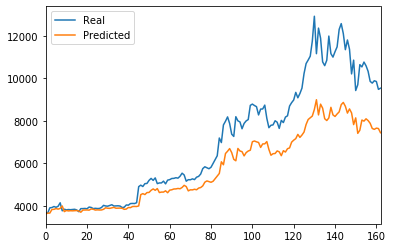

In [23]:
# Plot of the real vs predicted values as a line chart
stocks.plot()